In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('Boston.csv')
df = df.drop(columns = ['Unnamed: 0'])
df = pd.get_dummies(df, columns = ['rad'])
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,1,0,0,0,0,0,0,0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,0,1,0,0,0,0,0,0,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,0,1,0,0,0,0,0,0,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,0,0,1,0,0,0,0,0,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,0,0,1,0,0,0,0,0,0


In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color = "darkmagenta")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color ="lightseagreen")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

In [4]:
df['rm2'] = df['rm']**2

df['log_age'] = np.log(df['age'])
df['log_tax'] = np.log(df['tax'])
df['log_nox'] = np.log(df['nox'])
df['log_dis'] = np.log(df['dis'])
df['log_ptratio'] = np.log(df['ptratio'])

df['zn_tax'] = df['zn'] * df['tax']
df['nox_dis'] = df['dis'] * df['nox'] 
df['lstat_indus'] = df['indus'] * df['lstat']

df['nox_age'] = np.log(df['age']) / np.log(df['nox'])
df['age_dis'] = df['age'] / df['dis']


In [5]:
target = 'medv'
y = df[target]
X_otro = df.copy()
X_otro = X_otro.drop(target, axis = 1)

# Mejor Modelo

In [6]:
degree = 2

scaler = StandardScaler().fit(X_otro)
X_scaled = scaler.transform(X_otro)

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

model = linear_model.Ridge().fit(X_train, y_train)
 
predicciones_poly2_nuevo_fe = model.predict(X_test)
r2_score(y_pred=predicciones_poly2_nuevo_fe, y_true=y_test)

0.9029265037601136

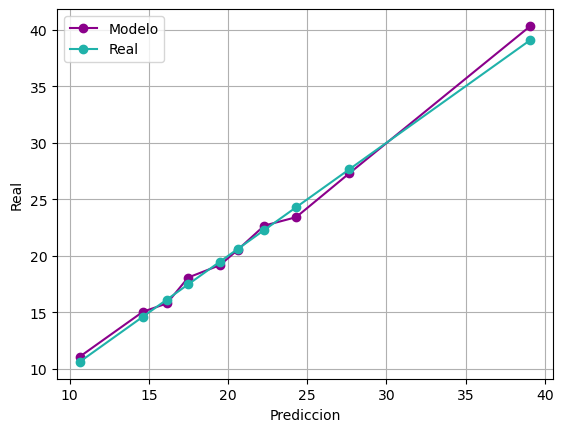

In [7]:
calibracion(predicciones_poly2_nuevo_fe, y_test, bins = 10)

### Análisis:

- El mejor modelo obtenido fue el de **regresión polinomial de grado 2 utilizando feature engineering y sin eliminar ninguna variable**. Este modelo obtuvo un **R2 de 0.9029**, lo cual significa que el modelo explica el 90.29% de la variación de los datos. Este R2 es muy bueno, indicando una buena precisión del modelo al momento de ajustarse a los datos reales.

# Random Forest

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_otro, y, test_size=0.3, random_state=42)

In [11]:
len(X_train.keys())

31

In [32]:

pipeline = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=300, n_jobs = -1))
])

params = {
    'rf__max_depth': [20, 25, 20, 35, 40],
    'rf__max_features': ['log2', 'sqrt', 28, 29, 20, 31]
}

rf_grid = GridSearchCV(estimator=pipeline, n_jobs = -1, cv=5, scoring='r2', param_grid=params)
rf_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_estimators=300,
                                                              n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [20, 25, 20, 35, 40],
                         'rf__max_features': ['log2', 'sqrt', 28, 29, 20, 31]},
             scoring='r2')

In [33]:
rf_grid.best_params_

{'rf__max_depth': 20, 'rf__max_features': 'sqrt'}

In [34]:
best_model =rf_grid.best_estimator_.named_steps['rf']

predicciones_rf = best_model.predict(X_test)

r2_score(y_pred = predicciones_rf, y_true=y_test)

0.8875431418379854

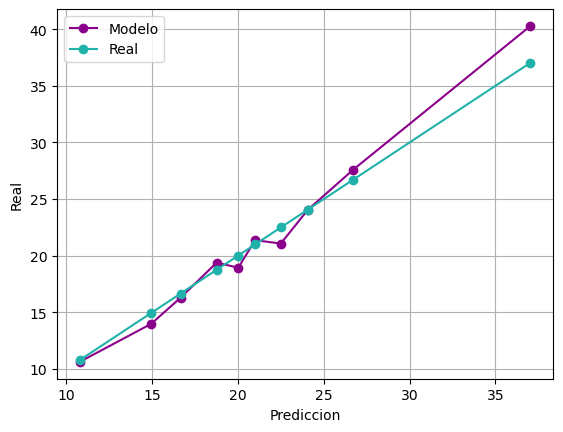

In [35]:
calibracion(predicciones_rf, y_test, bins = 10)

### Análisis:

- Tras realizar un random forest con distintas combinaciones, podemos apreciar que se obtuvo un R2 de 0.8875. Esto significa que el 88.75% de la variación de los datos es explicada por este modelo. Esto se obtuvo con 300 árboles con 20 niveles de profuncidad. 

- Por otro lado, en el examen, utilizando una regresión polinomial de grado 2, se obtuvo un R2 de 0.9029. ESto nos indica que el modelo explica el 90.29% de la variación de los datos. 

- Como podemos ver, se obtuvo un valor de R2 mayor utilizando una regresión polynomial de grado 2. Además, en las gráficas de calibración, se puede ver claramente como el primer modelo se ajusta un pcoo mejor a los datos reales. 